This notebook is used to do some exploratory analyses on the MovieLens 1m dataset

In [1]:
import os
from collections import defaultdict
from datetime import datetime, timedelta

import h5py
import numpy as np
import pandas as pd
import matplotlib._color_data as mcd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import gridspec
from scipy.stats import mannwhitneyu
import seaborn as sns 

plt.style.use('seaborn-white')
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', titlesize=16, labelsize=14)
mpl.rc('legend', fontsize=14)


In [2]:
DATA_DIR = './data/'
OUTPUT_DIR = './figures'

In [3]:
ratings = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m', 'ratings.dat'), sep='::', engine='python', header=None)
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
def get_movie_gender_info(df):
    gender_movies = defaultdict(set)
    movie_to_gender = {}
    for row in movies.itertuples():
        gender_movies[row.model_attr].add(row.movie_id)
        movie_to_gender[row.movie_id] = row.model_attr
    return gender_movies, movie_to_gender

movies = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m', 'movies.attr.csv'))
gender_movies, movie_to_gender = get_movie_gender_info(movies)

In [5]:
users = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m', 'users.dat'), sep='::', engine='python', header=None)
users.columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
age_mapping = {  
    1:  "<18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49", 
    50:  "50-55",
    56:  ">56"
}
users = users.replace({'age': age_mapping})
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,<18,10,48067
1,2,M,>56,16,70072
2,3,M,25-34,15,55117
3,4,M,45-49,7,02460
4,5,M,25-34,20,55455


In [7]:
result = users.groupby(['gender', 'age']).size() / len(users)
result = result.reindex([('F', v) for v in age_mapping.values()] + [('M', v) for v in age_mapping.values()])

In [8]:
GENDER_COLORS = {
    'F': '#20dfc6',
    'M': '#ff5c33'
}

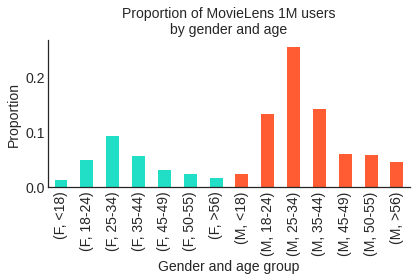

In [9]:
plt.figure(figsize=(6, 4))
plt.title('Proportion of MovieLens 1M users\nby gender and age', fontsize=14)
result.plot.bar(color=[GENDER_COLORS[k[0]] for k in result.index.tolist()])
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Gender and age group', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'movielens.prop_users.gender_age.pdf'), dpi=300)

In [10]:
ratings = pd.merge(left=ratings, right=users, left_on='user_id', right_on='user_id')

In [11]:
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code
0,1,1193,5,978300760,F,<18,10,48067
1,1,661,3,978302109,F,<18,10,48067
2,1,914,3,978301968,F,<18,10,48067
3,1,3408,4,978300275,F,<18,10,48067
4,1,2355,5,978824291,F,<18,10,48067


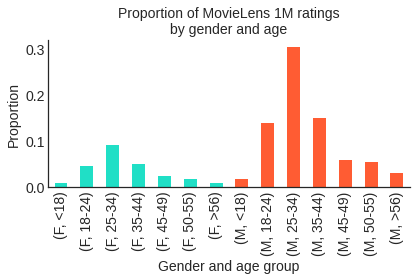

In [12]:
result = ratings.groupby(['gender', 'age']).size() / len(ratings)
result = result.reindex([('F', v) for v in age_mapping.values()] + [('M', v) for v in age_mapping.values()])
plt.figure(figsize=(6, 4))
plt.title('Proportion of MovieLens 1M ratings\nby gender and age', fontsize=14)
result.plot.bar(color=[GENDER_COLORS[k[0]] for k in result.index.tolist()])
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Gender and age group', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'supplementary-movielens.prop_ratings.gender_age.pdf'), dpi=300)

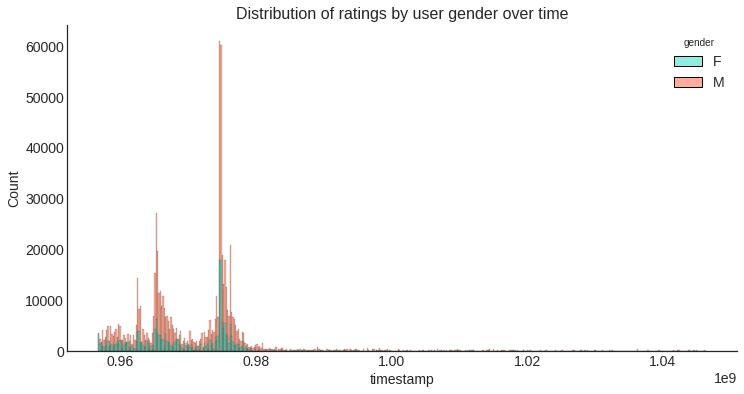

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data=ratings, x='timestamp', hue='gender',
             palette=GENDER_COLORS)
plt.title('Distribution of ratings by user gender over time')
plt.show()

## Differences in rating by gender

In [14]:
gender_avg_rating = defaultdict(list)
gender_N_ratings = defaultdict(list)

for u_id, u_df in ratings.groupby('user_id'):
    gender = users[users['user_id'] == u_id]['gender'].tolist()[0]
    gender_avg_rating[gender].append(np.average(u_df['rating'].values))
    gender_N_ratings[gender].append(len(u_df))

The average rating a female-identifying user assigns a movie is generally higher. Note this doesn't necessarily mean that the movie recommendations females receive are better - one possible explanation that we can't verify is that perhaps female users are more likely to only rate movies that they like. We also see that female users generally rate fewer movies than male users.

In [15]:
# Shows that the difference is statistically significant - note we use this a few times in the notebook
# but don't apply any sort of multiple testing correction, so take this with a grain of salt
mannwhitneyu(gender_avg_rating['F'], gender_avg_rating['M'], alternative='greater')

MannwhitneyuResult(statistic=3881977.0, pvalue=0.0015015478615958843)

In [16]:
"Average rating per user: F = {0:.2f}, M = {1:.2f}".format(
    np.average(gender_avg_rating['F']), np.average(gender_avg_rating['M']))

'Average rating per user: F = 3.73, M = 3.69'

In [17]:
mannwhitneyu(gender_N_ratings['F'], gender_N_ratings['M'], alternative='less')

MannwhitneyuResult(statistic=3315703.0, pvalue=1.3998233485733903e-10)

In [18]:
"Average number of ratings per user: F = {0:.2f}, M = {1:.2f}".format(
    np.average(gender_N_ratings['F']), np.average(gender_N_ratings['M']))

'Average number of ratings per user: F = 144.20, M = 174.04'

For each user, if we segment by each user's earlier half and later half of ratings, we see that all users seem to rate less positively in the later half of their time on MovieLens

In [19]:
early_gender_ratings = defaultdict(list)
late_gender_ratings = defaultdict(list)

for u_id, u_df in ratings.groupby('user_id'):
    u_df = u_df.sort_values('timestamp')
    gender = users[users['user_id'] == u_id]['gender'].tolist()[0]
    user_ratings = u_df['rating'].values
    half = len(u_df) // 2
    early_gender_ratings[gender].append(np.average(user_ratings[:half]))
    late_gender_ratings[gender].append(np.average(user_ratings[half:]))

In [20]:
print('Average ratings in first half of user history: F = {0:.2f}, M = {1:.2f}'.format(
    np.average(early_gender_ratings['F']), np.average(early_gender_ratings['M'])))

Average ratings in first half of user history: F = 3.76, M = 3.74


In [21]:
print('Average ratings in second half of user history: F = {0:.2f}, M = {1:.2f}'.format(
    np.average(late_gender_ratings['F']), np.average(late_gender_ratings['M'])))

Average ratings in second half of user history: F = 3.70, M = 3.65


Segmenting users by time doesn't show much difference in user ratings.  

In [22]:
sorted_ratings = ratings.sort_values('timestamp')
sorted_ratings = sorted_ratings[sorted_ratings['timestamp'] < 0.98 * 1e9]
sorted_ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code
1000138,6040,858,4,956703932,M,25-34,6,11106
1000153,6040,2384,4,956703954,M,25-34,6,11106
999873,6040,593,5,956703954,M,25-34,6,11106
1000007,6040,1961,4,956703977,M,25-34,6,11106
1000192,6040,2019,5,956703977,M,25-34,6,11106


In [23]:
mid_time = sorted_ratings['timestamp'].min() + \
           (sorted_ratings['timestamp'].max() - sorted_ratings['timestamp'].min()) // 2

In [24]:
user_start_end = []
user_start_end_dict = {}
for g_id, group in sorted_ratings.groupby(by='user_id'):
    user_start_end.append({
        'user_id': g_id,
        'gender': users[users['user_id'] == g_id]['gender'].values[0],
        'start_timestamp': group['timestamp'].min(),
        'end_timestamp': group['timestamp'].max(),
        'average_rating': np.average(group['rating']),
        'n_ratings': len(group)
    })
    user_start_end_dict[g_id] = (group['timestamp'].min(), group['timestamp'].max())

In [25]:
early_gender_ratings = defaultdict(list)
late_gender_ratings = defaultdict(list)

sorted_users = sorted_ratings['user_id'].unique()
for ix, user_id in enumerate(sorted_users):
    u_df = sorted_ratings[sorted_ratings['user_id'] == user_id]
    gender = users[users['user_id'] == user_id]['gender'].tolist()[0]
    if user_start_end_dict[user_id][0] < mid_time:
        early_gender_ratings[gender].append(np.average(u_df['rating'].values))
    else:
        late_gender_ratings[gender].append(np.average(u_df['rating'].values))

In [26]:
print('Difference in average rating between 1st half users versus second half: '
      'F = {0:.2f} - {1:.2f} = {2:.2f}'.format(
    np.average(early_gender_ratings['F']), np.average(late_gender_ratings['F']), 
    np.average(early_gender_ratings['F']) - np.average(late_gender_ratings['F']),))

Difference in average rating between 1st half users versus second half: F = 3.74 - 3.72 = 0.02


In [27]:
mannwhitneyu(early_gender_ratings['F'], late_gender_ratings['F'], alternative='greater')

MannwhitneyuResult(statistic=379663.5, pvalue=0.051404834244087115)

In [28]:
print('Difference in average rating between 1st half users versus second half: '
      'M = {0:.2f} - {1:.2f} = {2:.2f}'.format(
    np.average(early_gender_ratings['M']), np.average(late_gender_ratings['M']), 
    np.average(early_gender_ratings['M']) - np.average(late_gender_ratings['M']),))

Difference in average rating between 1st half users versus second half: M = 3.70 - 3.70 = 0.00


## Differences in use duration by gender

In [29]:
ratings['timestamp_dt'] = pd.to_datetime(ratings['timestamp'].apply(
    lambda d: datetime.fromtimestamp(d).strftime('%Y-%m-%d')))

user_start_end = []
for g_id, group in ratings.groupby(by='user_id'):
    n_days = (group['timestamp_dt'].max() - group['timestamp_dt'].min())
    user_start_end.append({
        'user_id': g_id,
        'gender': users[users['user_id'] == g_id]['gender'].values[0],
        'start': group['timestamp_dt'].min(),
        'end': group['timestamp_dt'].max(),
        'n_days': (group['timestamp_dt'].max() - group['timestamp_dt'].min()).days,
        'n_sec': (group['timestamp'].max() - group['timestamp'].min())

    })

In [30]:
use_rate_df = pd.DataFrame(user_start_end)

timebin_label = {
    0: '< 1 day',
    1: '1-14 days',
    2: '7-14 days',
    3: '> 14 days'
}
manual_timebin = []
for days in use_rate_df['n_days'].tolist():
    if days == 0:
        manual_timebin.append(0)
    elif days > 0 and days <= 7:
        manual_timebin.append(1)
    elif days > 7 and days <= 14:
        manual_timebin.append(2)
    else:
        manual_timebin.append(3)
use_rate_df['timebin'] = manual_timebin

In [31]:
agg_rate_df = use_rate_df.groupby(['gender', 'timebin']).size()
agg_rate_df = agg_rate_df.reset_index()

In [32]:
agg_rate_df['time label'] = [timebin_label[k] for k in agg_rate_df['timebin']]

In [33]:
N_female = len(use_rate_df[use_rate_df['gender'] == 'F'])
N_male = len(use_rate_df[use_rate_df['gender'] == 'M'])
agg_rate_df['prop'] = np.hstack([
    agg_rate_df[agg_rate_df['gender'] == 'F'][0].values / N_female, 
    agg_rate_df[agg_rate_df['gender'] == 'M'][0].values / N_male])
agg_rate_df.head()

,gender,timebin,0,time label,prop
0,F,0,1051,< 1 day,0.614980
1,F,1,197,1-14 days,0.115272
2,F,2,43,7-14 days,0.025161
3,F,3,418,> 14 days,0.244587
4,M,0,2475,< 1 day,0.571462


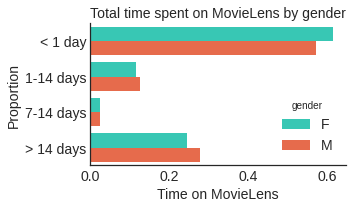

In [34]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(data=agg_rate_df, y='timebin', x='prop',
            hue='gender', palette=GENDER_COLORS,
            orient='h')
ax.set_yticklabels(agg_rate_df['time label'].values)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Time on MovieLens', fontsize=14)
plt.title('Total time spent on MovieLens by gender', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'movielens.user_history_length.pdf'), dpi=300)

These differences are significant by rank sum test (applied the test to day-level and second-level timestamps and found it was significant for both)

In [35]:
mannwhitneyu(
    use_rate_df[use_rate_df['gender'] == 'F']['n_days'].values, 
    use_rate_df[use_rate_df['gender'] == 'M']['n_days'].values,
    alternative='less')

MannwhitneyuResult(statistic=3532476.5, pvalue=0.001027504779079278)

In [36]:
mannwhitneyu(
    use_rate_df[use_rate_df['gender'] == 'F']['n_sec'].values, 
    use_rate_df[use_rate_df['gender'] == 'M']['n_sec'].values,
    alternative='less')

MannwhitneyuResult(statistic=3500474.5, pvalue=0.0005146323207489236)

Try to see differences in churn rate. A user is counted at the start of the time segment if their first and last ratings are before the start of the segment (i.e. you can consider them an active user at the start of the segment), and "churned" or dropped off if their last rating is on or before the end of the segment.

In [37]:
ratings = ratings[ratings['timestamp'] < 0.98 * 1e9]

In [38]:
start = ratings['timestamp_dt'].min()
end = ratings['timestamp_dt'].max() 
start, end

(Timestamp('2000-04-25 00:00:00'), Timestamp('2001-01-20 00:00:00'))

In [39]:
segments = [start + timedelta(x) for x in range(1, (end - start).days, 1)]

In [40]:
def get_churn(user_start_end, use_attr=None):
    # number of users at the start of the segment
    count_per_segment = defaultdict(int)  
    for ix, next_m in enumerate(segments[1:]):
        curr_m = segments[ix]
        for u in user_start_end:
            # if we are filtering by gender, skip if doesn't match
            if use_attr is not None and u['gender'] != use_attr:
                continue
            u_start, u_end = u['start'], u['end']
            # user starts before the segment and doesn't end before the segment
            if u_start <= curr_m and u_end > curr_m:
                count_per_segment[(curr_m, next_m)] += 1
    segment_dropoff = defaultdict(int)
    for ix, next_m in enumerate(segments[1:]):
        curr_m = segments[ix]
        for u in user_start_end:
            if use_attr is not None and u['gender'] != use_attr:
                continue
            u_start, u_end = u['start'], u['end']
            if u_start <= curr_m and u_end > curr_m and u_end <= next_m:
                segment_dropoff[(curr_m, next_m)] += 1
    
    churn_rate = {}
    for curr_m, next_m in count_per_segment.keys():
        count_users_start = count_per_segment[(curr_m, next_m)]
        users_dropped = segment_dropoff[(curr_m, next_m)]
        churn_rate[curr_m] = users_dropped / count_users_start
    return churn_rate

In [41]:
churn_baseline = get_churn(user_start_end)
churn_male = get_churn(user_start_end, use_attr='M')
churn_female = get_churn(user_start_end, use_attr='F')

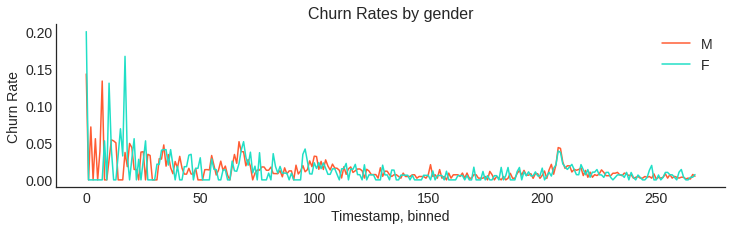

In [42]:
segments = list(churn_baseline.keys())
xs = list(range(len(segments)))

plt.figure(figsize=(12, 3))
plt.plot(xs, list(churn_male.values()), label='M', c=GENDER_COLORS['M'])
plt.plot(xs, list(churn_female.values()), label='F', c=GENDER_COLORS['F'])
plt.legend()
plt.xlabel('Timestamp, binned', fontsize=14)
plt.ylabel('Churn Rate', fontsize=14)
plt.title('Churn Rates by gender')
plt.savefig(os.path.join(OUTPUT_DIR, 'supplementary-movielens.churn_rate.pdf'), dpi=300)

In [43]:
mannwhitneyu(list(churn_female.values()), list(churn_male.values()), alternative='less')

MannwhitneyuResult(statistic=31142.0, pvalue=0.003763328232736797)

In [44]:
'Average churn rate: M = {0:.3f}, F = {1:.3f}'.format(
    np.average(list(churn_male.values())), np.average(list(churn_female.values())))

'Average churn rate: M = 0.013, F = 0.012'

## Movie gender stereotype and ratings

In [45]:
SEGMENTS = [('M', 'M'), ('M', 'F'), ('M', 'MF'),
            ('F', 'F'), ('F', 'M'), ('F', 'MF')]

# ratings data with movie gender stereotype information included
data_df = pd.read_csv(os.path.join(DATA_DIR, 'df_movielens_1m.csv'))

summ_stat_df = (data_df.groupby(['user_attr', 'model_attr']).size() 
                / len(data_df)).reset_index()
summ_stat_df.rename(columns={0: 'proportion'}, inplace=True)

summ_stat_df['average_rating'] = (data_df.groupby(['user_attr', 'model_attr']).mean()['rating'].tolist())
display(summ_stat_df)

,user_attr,model_attr,proportion,average_rating
0,F,F,0.052598,3.665533
1,F,M,0.159689,3.578274
2,F,MF,0.034102,3.747808
3,M,F,0.107000,3.520659
4,M,M,0.562347,3.560097
5,M,MF,0.084264,3.688712


In [52]:
def get_movie_prop_rows(prop_list, name):
    rows = []
    movie_attr = movies['model_attr'].unique()
    for mgroup, prop in zip(movie_attr, prop_list):
        rows.append({
            'movie gender stereotype': mgroup,
            'proportion of ratings': prop,
            'user group': name
        })
    return rows

alldata_list = (movies.groupby(['model_attr']).size() / len(movies)).values
female_users_list = (
    summ_stat_df[summ_stat_df['user_attr'] == 'F']['proportion'] 
    / np.sum(summ_stat_df[summ_stat_df['user_attr'] == 'F']['proportion']))
male_users_list = (
    summ_stat_df[summ_stat_df['user_attr'] == 'M']['proportion'] 
    / np.sum(summ_stat_df[summ_stat_df['user_attr'] == 'M']['proportion']))

movie_stats = (
    get_movie_prop_rows(alldata_list, 'all') +
    get_movie_prop_rows(female_users_list, 'female') +
    get_movie_prop_rows(male_users_list, 'male'))
movie_stats_df = pd.DataFrame(movie_stats)
display(movie_stats_df)

,movie gender stereotype,proportion of ratings,user group
0,F,0.171259,all
1,M,0.607005,all
2,MF,0.221736,all
3,F,0.213476,female
4,M,0.648117,female
5,MF,0.138407,female
6,F,0.141982,male
7,M,0.746203,male
8,MF,0.111814,male


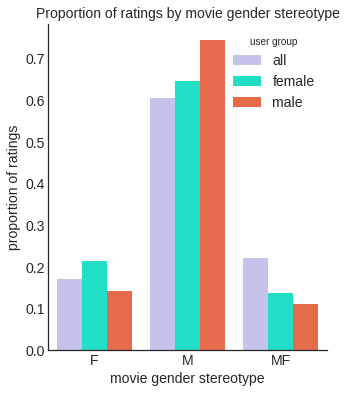

In [47]:
plt.figure(figsize=(5, 6))
sns.barplot(data=movie_stats_df, 
            x='movie gender stereotype', y='proportion of ratings',
            hue='user group',
            palette={'all': '#bdbef2', 'male': '#ff5c33', 'female': '#00ffdd'})
plt.title('Proportion of ratings by movie gender stereotype', fontsize=14)
plt.savefig(os.path.join(OUTPUT_DIR, 'movielens.prop_ratings.movie_gender.pdf'), dpi=300)

In [48]:
def plot_avg_by_segment(df_review, user_attr, metric, figsize, 
                        index_ord=None, savefile=None):
    """
    Code modified from Wan et al. 
    https://github.com/MengtingWan/marketBias/blob/master/analysis.ipynb
    """
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby([user_attr, 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby([user_attr, 'model_attr'])[metric].sem().unstack()
    
    group_rating.index = group_rating.index.rename('user {0}'.format(user_attr))
    group_rating.columns = group_rating.columns.rename('movie gender')
    if index_ord is not None:
        group_rating = group_rating.loc[index_ord]
    
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(
                str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+
                str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="OrRd", annot_kws={"size": 13},
                cbar=False)
    if savefile is not None:
        fig.savefig(os.path.join(
            OUTPUT_DIR, 'movielens.ratings_obs_heatmap.{0}.pdf'.format(savefile)),
                    bbox_inches='tight')

In [49]:
movies = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m', 'movies.attr.csv'))
mi_ratings = pd.merge(left=ratings, right=movies, left_on='movie_id', right_on='movie_id')
mi_ratings['gender & age'] = [
    '{0} {1}'.format(g, a) for (g, a) in 
    zip(mi_ratings['gender'].tolist(), mi_ratings['age'].tolist())]

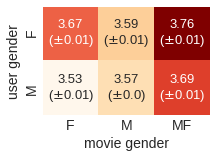

In [50]:
plot_avg_by_segment(mi_ratings, 'gender', 'rating', (3, 2), savefile='gender')

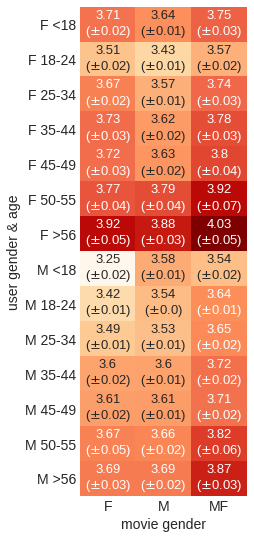

In [51]:
index_ord = ['F <18', 'F 18-24', 'F 25-34', 'F 35-44', 'F 45-49', 'F 50-55', 'F >56', 'M <18', 'M 18-24', 'M 25-34', 'M 35-44', 'M 45-49', 'M 50-55', 'M >56']
plot_avg_by_segment(
    mi_ratings, 'gender & age', 'rating', (3, 9),
    index_ord=index_ord, savefile='gender_age')